In [1]:
from train_module import *
import helper_code as hc
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve,auc
from sklearn.preprocessing import label_binarize
import random

def plot_confusion_matrix(y_true, y_pred, class_names, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    colormaps = ['Blues', 'Oranges', 'Greens', 'Purples']
    cmap = random.choice(colormaps)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels
    = class_names)
    fig, ax = plt.subplots(figsize=(15, 10))    
    disp.plot(ax=ax, cmap=cmap, colorbar=True)
    plt.title(title)
    plt.xticks(rotation=90, fontsize=9)
    plt.yticks(fontsize=9)
    plt.grid(False)
    plt.tight_layout()
    plt.show()
    return 0

## dataset
From the Physionet Challange 2021, the total dataset is combined with 7 data scources, 
1. CPSC Database and CPSC-Extra Database 
2. INCART Database 
3. PTB and PTB-XL Database 
4. The Georgia 12-lead ECG Challenge (G12EC) Database 
5. Augmented Undisclosed Database 
6. Chapman-Shaoxing and Ningbo Database 
7. The University of Michigan (UMich) Database 

And at this stage, i only choose the sixth souce as my training, the next stage is to choose bigger dataset and more data sources to train and valiation the model. 

The sixth source is the Chapman University, Shaoxing People’s Hospital (Chapman-Shaoxing) and Ningbo First Hospital (Ningbo) database. This source contains 45,152 ECGS (all shared as training data). Each recording is 10 seconds long with a sampling frequency of 500 Hz. 

about the leads: 
after the investigation, i choose the II leads to train models, beacuse the most of the papers use the II leads to train the model, especially deploving on the portable equipment. 

about the data files:
The raw data file is combined with the .hea file and the .mat file, the .hea file contains the information of the name of recording file and recording frequency, and the next lines contain the information of each leads. The ley information in .hea file is # DX codes, witch are the labels of the sample.

### data visualization


count of each label: [ 68131  21405 123062 205480]


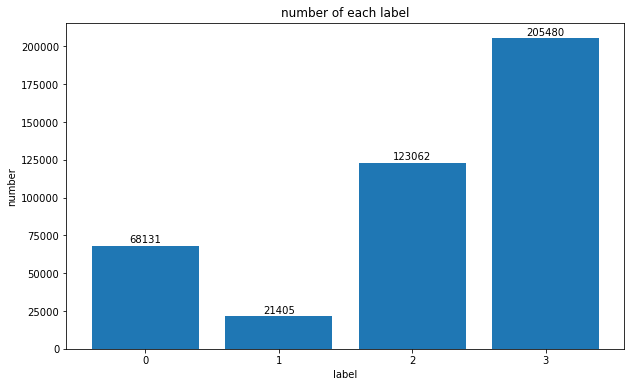

In [2]:
segments = np.load("D:\study\Msc project\project\data\segments.npy")
labels = segments[:,1000].astype(int)
unique_labels = np.unique(labels)
label_counts = np.bincount(labels)
print(f"count of each label: {label_counts}")

plt.figure(figsize=(10, 6))
plt.bar(unique_labels, [label_counts[i] for i in unique_labels])
plt.xlabel('label')
plt.ylabel('number')
plt.title('number of each label')
plt.xticks(unique_labels)

# 在柱状图上显示数值
for i, label in enumerate(unique_labels):
    plt.text(label, label_counts[label] + max(label_counts)*0.01, 
             str(label_counts[label]), ha='center')

plt.show()

the segment data show that the number of each label is not balanced, so we need to resample the data to make the number of label balanced.

count of each label: [40000 40000 40000 40000]


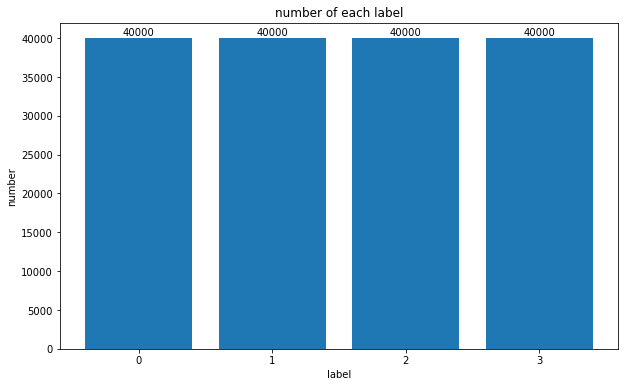

In [33]:
from sklearn.utils import resample
def resample_data(samples):
    samples_0 = [s for s in samples if s[1000] == 0]
    samples_1 = [s for s in samples if s[1000] == 1]
    samples_2 = [s for s in samples if s[1000] == 2]
    samples_3 = [s for s in samples if s[1000] == 3]
    samples_2_down = resample(samples_2, replace=False, n_samples=40000, random_state=42)
    samples_3_down = resample(samples_3, replace=False, n_samples=40000, random_state=42)
    samples_0_down = resample(samples_0, replace=False, n_samples=40000, random_state=42)
    samples_1_up = resample(samples_1, replace=True, n_samples=40000, random_state=42)
    balanced_samples = samples_0_down + samples_1_up + samples_2_down + samples_3_down
    balanced_samples = np.array(balanced_samples)
    return balanced_samples

segments = resample_data(segments)
labels = segments[:,1000].astype(int)
unique_labels = np.unique(labels)
label_counts = np.bincount(labels)
print(f"count of each label: {label_counts}")

plt.figure(figsize=(10, 6))
plt.bar(unique_labels, [label_counts[i] for i in unique_labels])
plt.xlabel('label')
plt.ylabel('number')
plt.title('number of each label')
plt.xticks(unique_labels)

# 在柱状图上显示数值
for i, label in enumerate(unique_labels):
    plt.text(label, label_counts[label] + max(label_counts)*0.01, 
             str(label_counts[label]), ha='center')

plt.show()

#### train the 1dcnn feed lstm model with raw signal (1*5000)


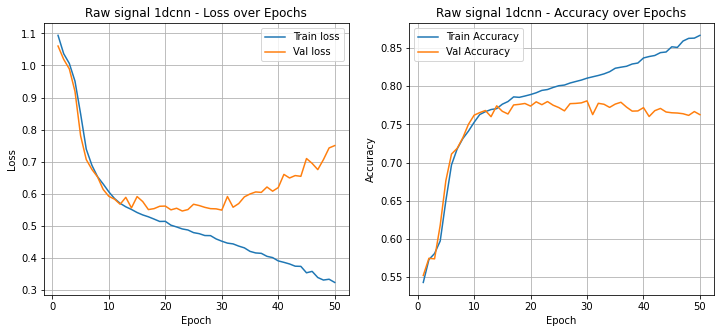

0

In [9]:
training_plots("D:/study/Msc project/project/traininglog/train_1d_v1.pt", "Raw signal 1dcnn")


According to the loss and acc plots, the model is undersatisfied, with strong overfitting and low acc, so i do data processing and try to do it again

#### train the 1dcnn feed lstm model with 1d segments (1*1000)(each segments contains 4 peaks)

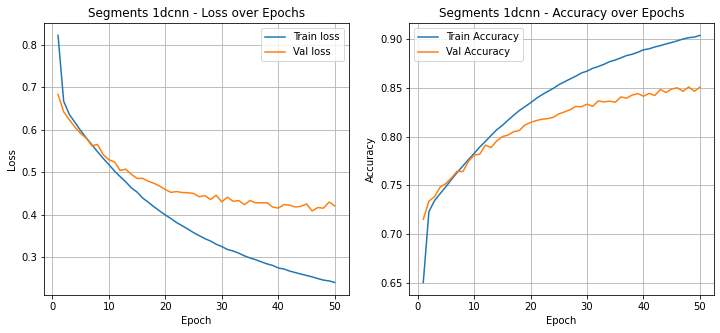

0

In [10]:
training_plots("D:/study/Msc project/project/traininglog/train_1d_segments.pt", "Segments 1dcnn")

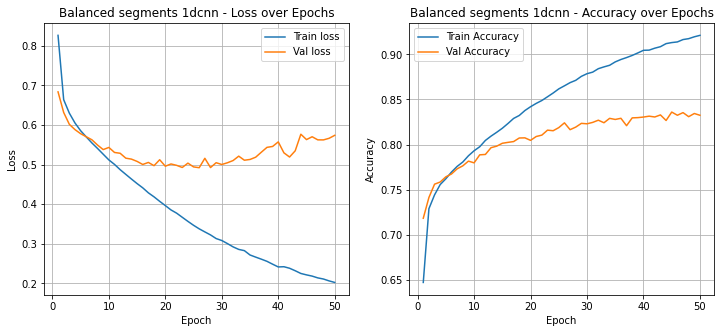

0

In [36]:
training_plots("D:/study/Msc project/project/traininglog/train_1d_segments_balanced.pt","Balanced segments 1dcnn")

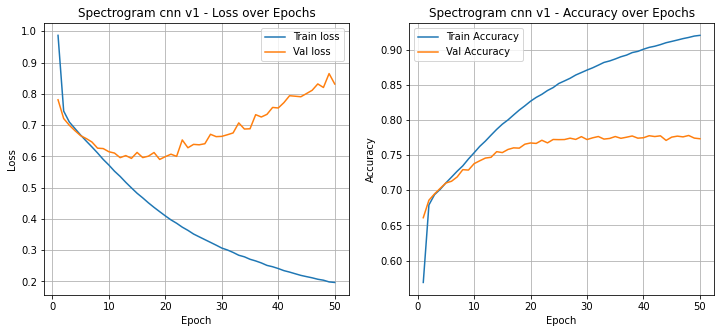

0

In [11]:
training_plots("D:/study/Msc project/project/traininglog/train_2d_3layers.pt", "Spectrogram cnn v1")

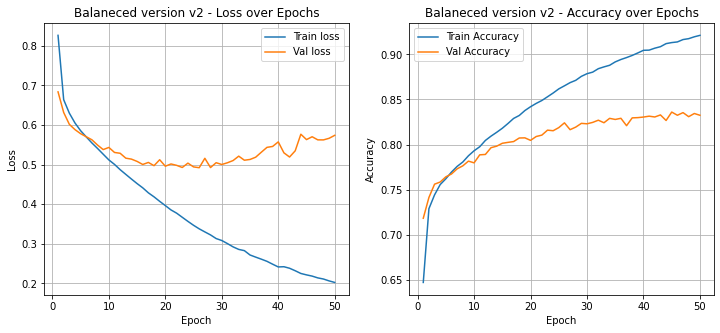

0

In [5]:
training_plots("D:/study/Msc project/project/traininglog/train_1d_segments_balanced.pt", "Balaneced version v2")

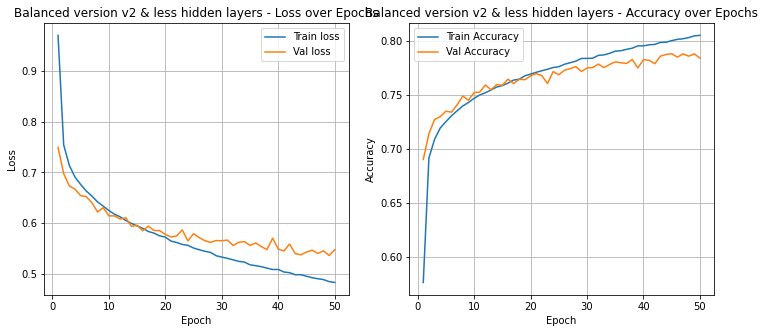

0

In [6]:
training_plots("D:/study/Msc project/project/traininglog/train_1d_segments_balanced_v3_less_hiddenlayer.pt", "Balanced version v2 & less hidden layers")

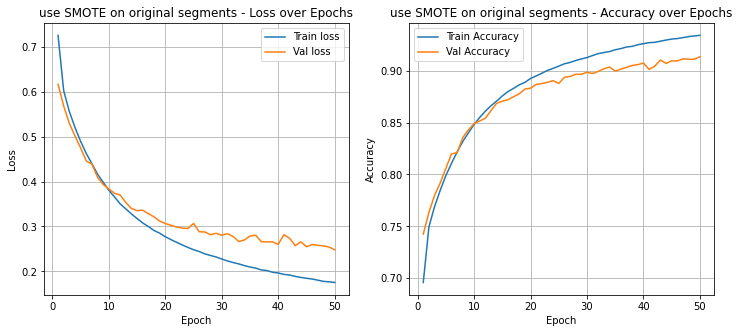

0

In [7]:
training_plots("D:/study/Msc project/project/traininglog/orignal_parm_with_SMOTE_orignal_segs.pt", "use SMOTE on original segments")

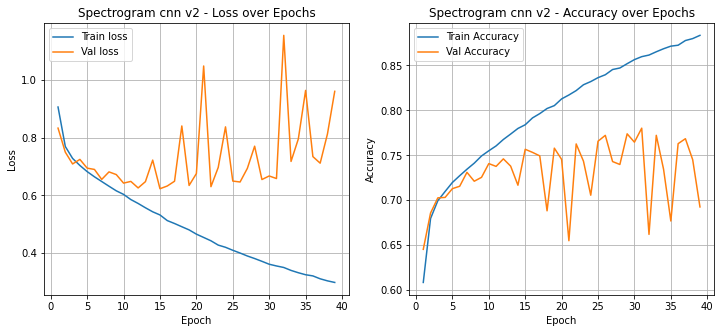

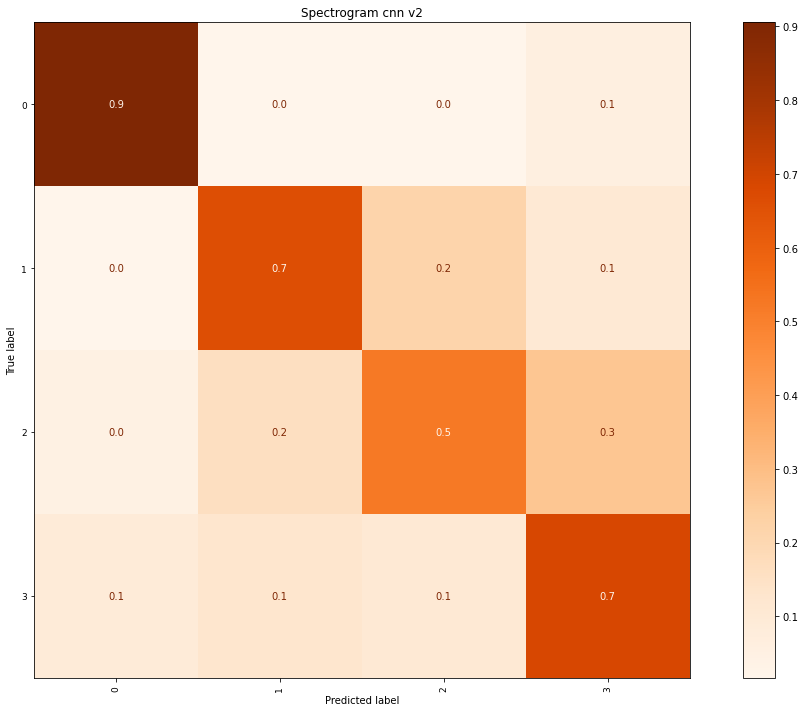

0

In [11]:
training_plots("D:/study/Msc project/project/traininglog/spectrogram_v2_with_better_balanced_segs_and_new_net.pt", "Spectrogram cnn v2")
results = torch.load("D:/study/Msc project/project/traininglog/spectrogram_v2_with_better_balanced_segs_and_new_net.pt") 
plot_confusion_matrix(results['y_true_val'], results['y_pred_val'], ["0", "1", "2", "3"], title="Spectrogram cnn v2")

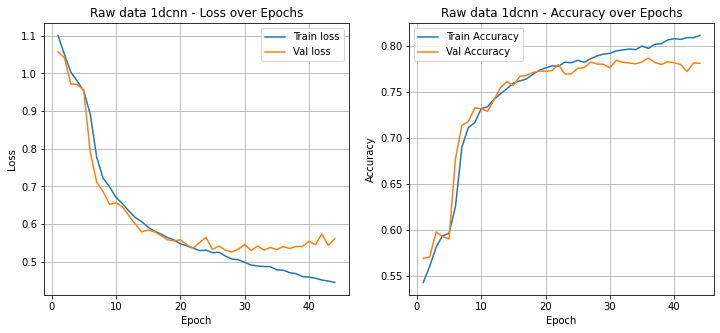

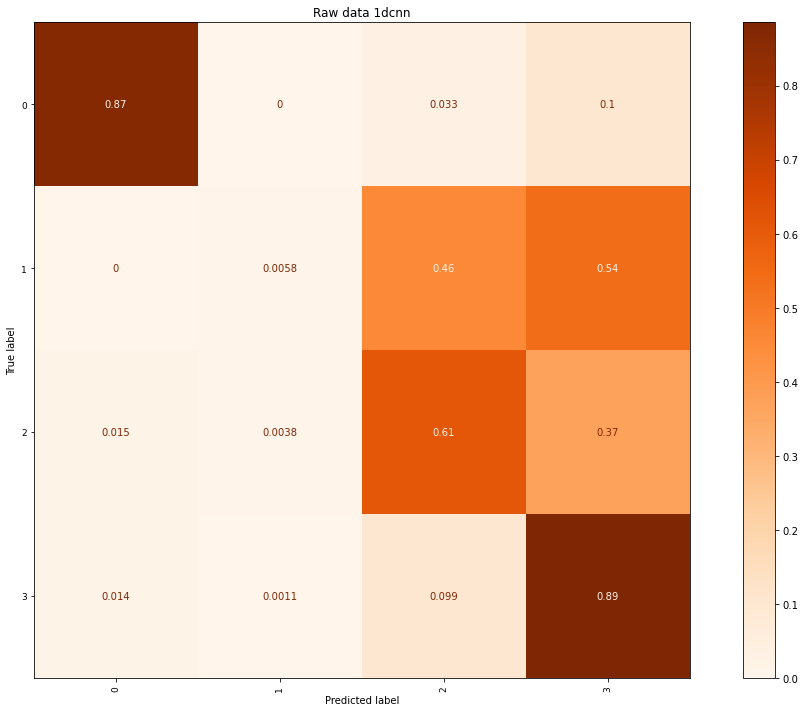

0

In [14]:
training_plots("D:/study/Msc project/project/traininglog/train_1d_raw_data.pt", "Raw data 1dcnn")
results = torch.load("D:/study/Msc project/project/traininglog/train_1d_raw_data.pt") 
plot_confusion_matrix(results['y_true_val'], results['y_pred_val'], ["0", "1", "2", "3"], title="Raw data 1dcnn")

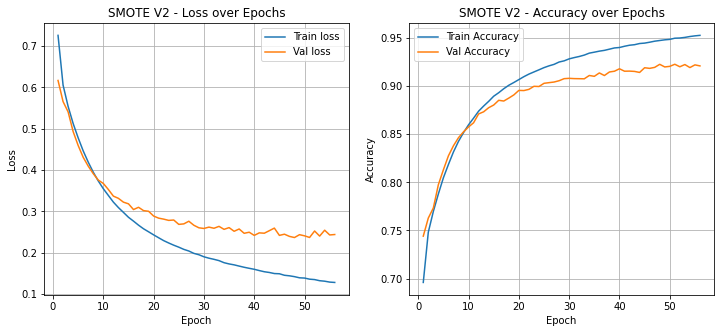

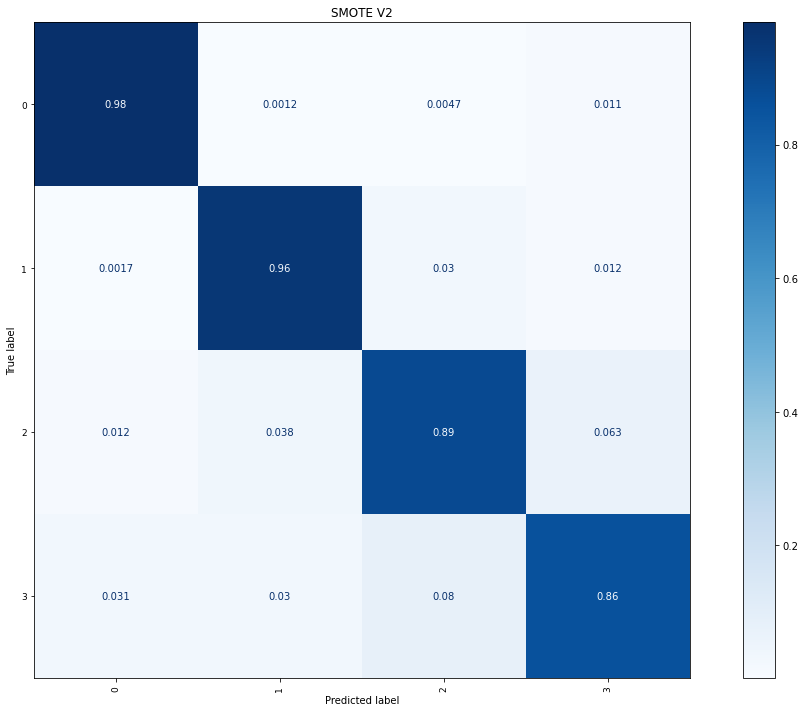

0

In [15]:
training_plots("D:/study/Msc project/project/traininglog/orignal_parm_with_SMOTE_orignal_segs_more_hls.pt", "SMOTE V2")
results = torch.load("D:/study/Msc project/project/traininglog/orignal_parm_with_SMOTE_orignal_segs_more_hls.pt") 
plot_confusion_matrix(results['y_true_val'], results['y_pred_val'], ["0", "1", "2", "3"], title="SMOTE V2")

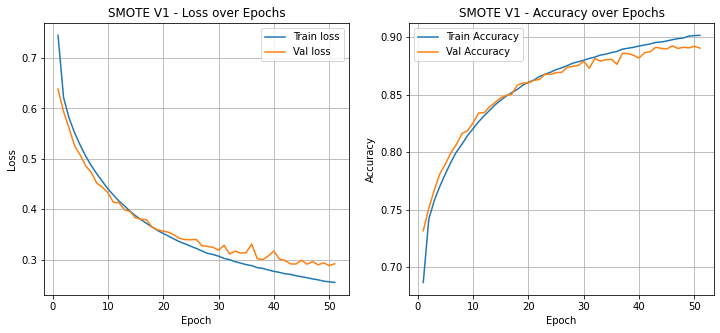

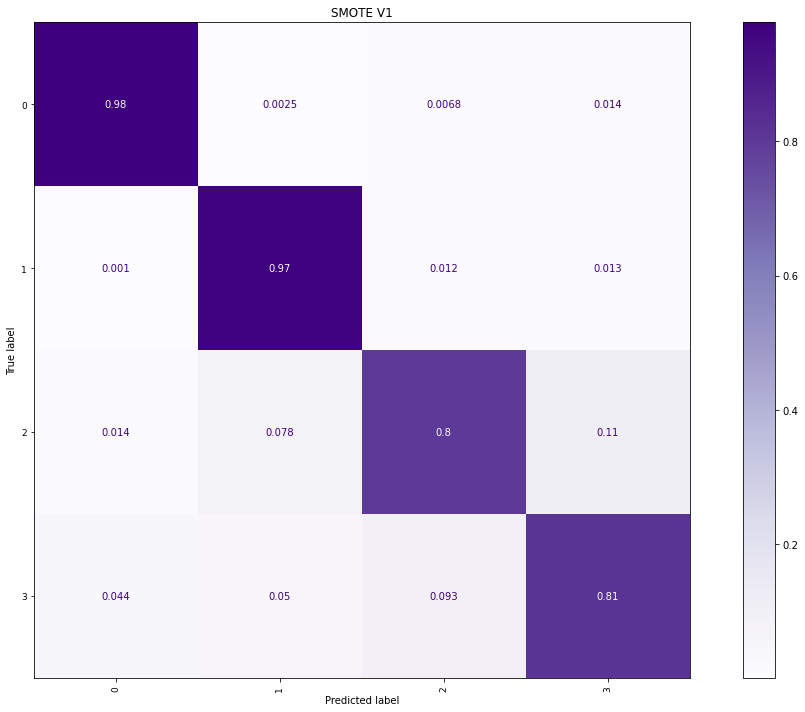

0

In [3]:
training_plots("D:/study/Msc project/project/traininglog/orignal_parm_with_SMOTE_orignal_segs.pt", "SMOTE V1")
results = torch.load("D:/study/Msc project/project/traininglog/orignal_parm_with_SMOTE_orignal_segs.pt") 
plot_confusion_matrix(results['y_true_val'], results['y_pred_val'], ["0", "1", "2", "3"], title="SMOTE V1")

In [15]:
import random
import os
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.preprocessing import label_binarize
def plot_confusion_matrix(y_true, y_pred, class_names, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    colormaps = ['Blues', 'Oranges', 'Greens', 'Purples']
    cmap = random.choice(colormaps)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels = class_names)
    fig, ax = plt.subplots(figsize=(15, 10))
    disp.plot(ax=ax, cmap=cmap, colorbar=True, values_format=".1f")
    plt.title(title)
    plt.xticks(rotation=90, fontsize=9)
    plt.yticks(fontsize=9)
    plt.grid(False)
    plt.tight_layout()
    plt.show()

    return 0

def plot_ROC_curve(y_true, y_score, class_names, topk=(2,2),title="ROC Curve"):
    y_true = np.array(y_true)
    y_score = np.array(y_score)
    n_classes = len(class_names)
    y_true_bin = label_binarize(y_true, classes = np.arange(n_classes))
    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    sorted_auc = sorted(roc_auc.items(), key=lambda x: x[1], reverse=True)
    selected = [idx for idx, _ in sorted_auc[:topk[0]] + sorted_auc[-topk[1]:]]

    plt.figure(figsize=(10, 8))
    for i in selected:
        plt.plot(fpr[i], tpr[i], label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

    return 0

def CNN_confusion_matrix_and_ROC(model_name):
    result = torch.load(f'D:/study/Msc project/project/traininglog/{model_name}')
    print(type(result['y_true_val']), result['y_true'])
    print(type(result['y_pred_val']), result['y_pred'])
    plot_confusion_matrix(result['y_true_val'], result['y_pred_val'],  [0,1,2,3],title= 'Validation Confusion Matrix' )
    plot_ROC_curve(result['y_true_val'], result['y_score'], [0,1,2,3], title='ROC Curves for Top-2 and Bottom-2 Classes')
    return 0

CNN_confusion_matrix_and_ROC("orignal_parm_with_SMOTE_orignal_segs.pt")

<class 'numpy.int64'> 0
<class 'numpy.int64'> 0


TypeError: Singleton array 3 cannot be considered a valid collection.

count of each label: [ 68131  21405 123062 205480]


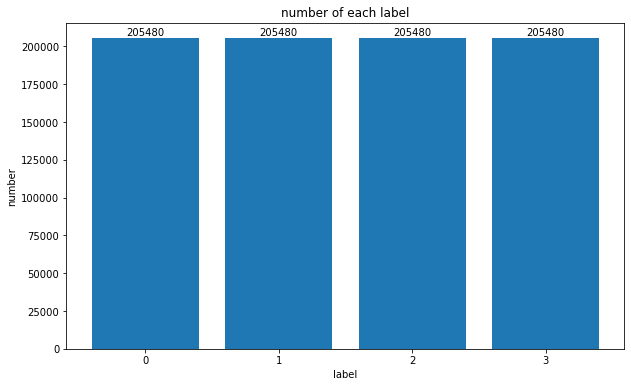

In [4]:
segments = np.load("D:\study\Msc project\project\data\segments.npy")
labels = segments[:,1000].astype(int)
unique_labels = np.unique(labels)
label_counts = np.bincount(labels)
print(f"count of each label: {label_counts}")
label_counts = [205480,205480,205480,205480]
plt.figure(figsize=(10, 6))
plt.bar(unique_labels, [label_counts[i] for i in unique_labels])
plt.xlabel('label')
plt.ylabel('number')
plt.title('number of each label')
plt.xticks(unique_labels)

# 在柱状图上显示数值
for i, label in enumerate(unique_labels):
    plt.text(label, label_counts[label] + max(label_counts)*0.01, 
             str(label_counts[label]), ha='center')

plt.show()

<Figure size 864x288 with 0 Axes>

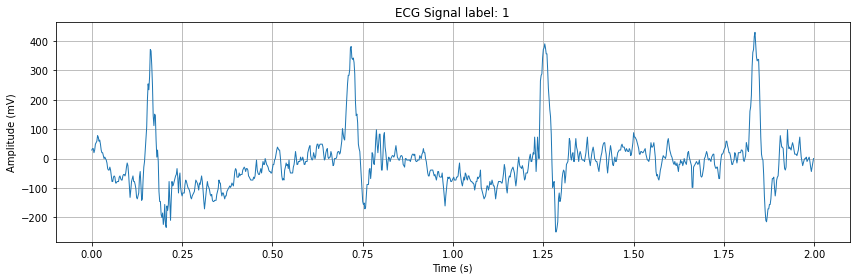

In [11]:
segments = np.load("D:\study\Msc project\project\data\segments.npy")
label = segments[4][1000].astype(int)
seg = segments[4][:1000]

fs = 500
time = np.arange(len(seg)) / fs
plt.figure(figsize=(12, 4))

plt.figure(figsize=(12, 4))
plt.plot(time, seg, linewidth=1)
plt.title(f"ECG Signal label: {label}")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (mV)")
plt.grid(True)
plt.tight_layout()
plt.show()

<Figure size 864x288 with 0 Axes>

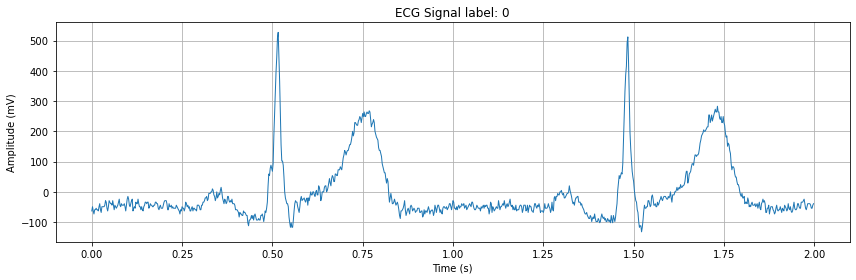

In [10]:
sample_0 = [s for s in segments if s[1000] == 0]
label = sample_0[4][1000].astype(int)
seg = sample_0[4][:1000]

fs = 500
time = np.arange(len(seg)) / fs
plt.figure(figsize=(12, 4))

plt.figure(figsize=(12, 4))
plt.plot(time, seg, linewidth=1)
plt.title(f"ECG Signal label: {label}")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (mV)")
plt.grid(True)
plt.tight_layout()
plt.show()


<Figure size 864x288 with 0 Axes>

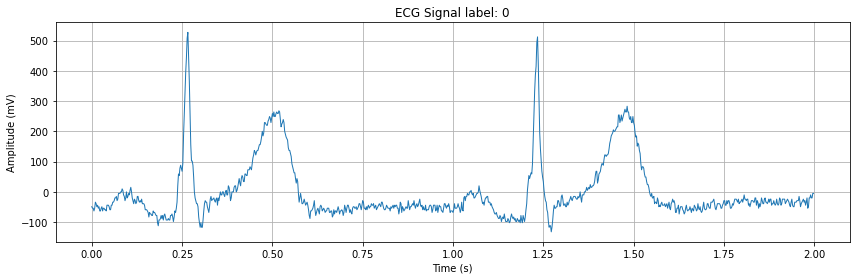

In [13]:
sample_2 = [s for s in segments if s[1000] == 2]
label = sample_0[5][1000].astype(int)
seg = sample_0[5][:1000]

fs = 500
time = np.arange(len(seg)) / fs
plt.figure(figsize=(12, 4))

plt.figure(figsize=(12, 4))
plt.plot(time, seg, linewidth=1)
plt.title(f"ECG Signal label: {label}")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (mV)")
plt.grid(True)
plt.tight_layout()
plt.show()


<Figure size 864x288 with 0 Axes>

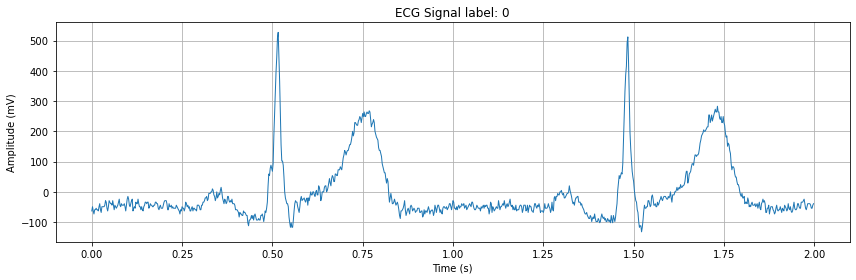

In [14]:
sample_3 = [s for s in segments if s[1000] == 3]
label = sample_0[4][1000].astype(int)
seg = sample_0[4][:1000]

fs = 500
time = np.arange(len(seg)) / fs
plt.figure(figsize=(12, 4))

plt.figure(figsize=(12, 4))
plt.plot(time, seg, linewidth=1)
plt.title(f"ECG Signal label: {label}")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (mV)")
plt.grid(True)
plt.tight_layout()
plt.show()
